In [1]:
# run under DIP environment
import os
import skimage.io as io
import scipy.io as sio
import numpy as np
import time
# import math

## Load Data

DD_PARS_blood (from out lab)

In [ ]:
file_name = r"test_RF.mat"
mat = sio.loadmat(file_name)
print(mat.keys())
img_down = mat["test"]
original_x, original_y = img_down.shape
print(original_x, original_y)
print(img_down)



dict_keys(['__header__', '__version__', '__globals__', 'test'])
2200 128
[[ 0. -0.  0. ...  0. -0.  0.]
 [-0. -0.  0. ...  0. -0. -0.]
 [-0. -0.  0. ...  0.  0. -0.]
 ...
 [ 0.  0. -0. ...  0. -0. -0.]
 [ 0. -0. -0. ... -0. -0.  0.]
 [ 0. -0.  0. ... -0. -0.  0.]]


In [3]:
from utils.expand_data import *
img_masked, img_mask = expand_data(img_down, original_x, original_y*3)

Plot the loaded data

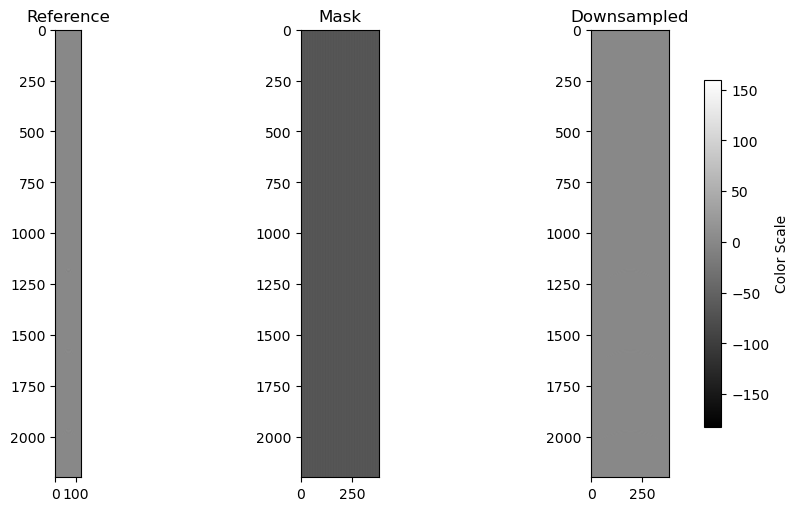

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

colormap = 'gray'
# plot each image
im1 = axes[0].imshow(img_down, cmap=colormap)
axes[0].set_title("Reference")

im2 = axes[1].imshow(img_mask, cmap = 'gray')
axes[1].set_title("Mask")

im3 = axes[2].imshow(img_masked,cmap=colormap)
axes[2].set_title("Downsampled")

# add colorbars
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Color Scale")

plt.show()


## Pre-work of DIP

In [5]:
import torch
import torch.optim
torch.__version__

'2.0.1'

Set inputs, hyperparameters and network architecture

In [6]:
img_np = np.expand_dims(img_masked, 0)  # expand the downsampled image to 3D numpy array (1, H, W)
mask_np = np.expand_dims(img_mask, 0)   # expand the mask to 3D numpy array (1, H, W)

from models.skip import skip
from utils.inpainting_utils import *

#from skimage.measure import compare_psnr,compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# setup
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.001 
num_iter = 1000
param_noise = False
show_every = 50
save_every = 10
figsize = 5
reg_noise_std = 0.03
    
net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [original_y*2] * 5,
           num_channels_up =   [original_y*2] * 5,
           num_channels_skip =    [4] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='bilinear', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype) # generate a random noise input tensor (1, input_depth, H, W)
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)   # convert numpy array to torch tensor (1, 1, H, W)
mask_var = np_to_torch(mask_np).type(dtype) # convert numpy array to torch tensor (1, 1, H, W)


Number of params: 8727525


Create the numpy to save the reults for each [save_every] iteration and processing time (in second)

In [7]:
out_log_np = np.zeros(shape = (num_iter//save_every, img_masked.shape[0], img_masked.shape[1]))
time_log_np = np.zeros(shape = (1, num_iter//save_every))

show the input noise

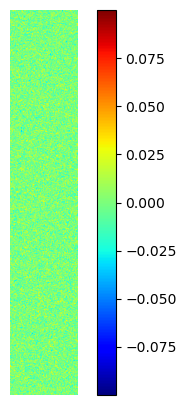

In [8]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(torch_to_np(net_input).transpose(1, 2, 0)[:,:,0], cmap='jet')   
plt.colorbar()

# DIP process

In [9]:
i = 0
psnr_history = [] 
loss_history = [] 
ssim_history = []
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)    # output of network (1, 1, H, W)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    psnr = compare_psnr(img_np, torch_to_np(out), data_range = 1.0)
    ssim = compare_ssim(img_np[0,:], torch_to_np(out)[0,:], data_range = 1.0)
    # History
    loss_history.append(total_loss.item())
    psnr_history.append(psnr)
    ssim_history.append(ssim)

    print ('Iteration %05d    Loss %f    PSNR %f    SSIM %f' % (i, total_loss.item(), psnr, ssim), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)   
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
    if i % save_every == 0:
        out_np = torch_to_np(out)[0,:]
        out_log_np[i//save_every, :, :] = out_np
        print(f'Elasped time:{round(time.time() - start_time, 3)}')
        time_log_np[0, i//save_every] = round(time.time() - start_time, 3)
    i += 1
    return total_loss

start_time = time.time()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


OutOfMemoryError: CUDA out of memory. Tried to allocate 826.00 MiB (GPU 0; 4.00 GiB total capacity; 10.42 GiB already allocated; 0 bytes free; 10.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Show the final output of DIP

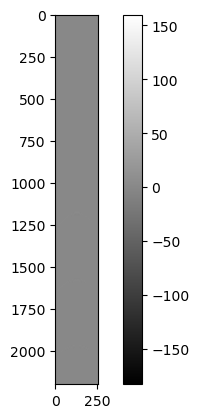

In [107]:
img_out = torch_to_np(net(net_input))[0,:]
plt.imshow(img_out, cmap='gray')
plt.colorbar()

Text(0.5, 1.0, 'Reconstructed')

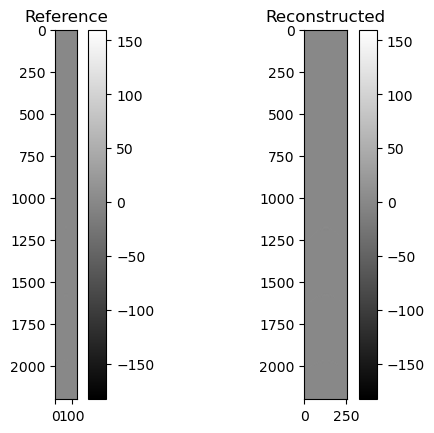

In [101]:
plt.subplot(1, 2, 1)
plt.imshow(img_down, cmap='gray')
plt.colorbar()
plt.title('Reference')
plt.subplot(1, 2, 2)
plt.imshow(img_out, cmap='gray')
plt.colorbar()
plt.title('Reconstructed')

In [102]:
print(f'Reference minimum: \t{img_down.min()},\tmaximum: {img_down.max()}')
print(f'Reconstructed minimum: \t{img_out.min()},\tmaximum: {img_out.max()}')

Reference minimum: 	-182.82730102539062,	maximum: 160.0046844482422
Reconstructed minimum: 	-182.70217895507812,	maximum: 159.96310424804688


In [46]:
torch.cuda.empty_cache()

In [ ]:
savemat("reconstruct_channel_data.mat", {"result":img_out})